In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv'
discov_df = pd.read_csv(discov_val_feats_path)
feats_list = pd.read_csv('noncorrolated_feature_list_2.csv', header=None)[0].to_list()
feats_list = [feat for feat in feats_list if feat not in ["mit_clusterCoff_max", "mit_hotspot_score"]]

df = discov_df[['type']+feats_list]
invalid_cancers = ['PCPG','DLBC','THYM','LAML','SARC','CHOL','ACC']
df = df[~df['type'].isin(invalid_cancers)]
# cancer_types = set(df.columns) - set(['PCPG','DLBC','THYM','LAML','SARC','CHOL','ACC'])
# df = df[df['type']==]


# Replace positive infinite values with the maximum finite value in the DataFrame
df = df.replace(np.inf, np.nan)
df = df.dropna()

df[feats_list] = df[feats_list].astype(float)
df_ref = deepcopy(df)
# df[feats_list] = df[feats_list].loc[:, df[feats_list].std() > 0]

PERCEPTIVE_COLORS = [
    # "#000000", # ! dont use black
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

from PIL import ImageColor

def hex_to_rgb_pillow(hex_string):
    r, g, b = ImageColor.getcolor(hex_string, "RGB")
    return r, g, b

# Example usage:
PERCEPTIVE_COLORS_RGB = []
for hex_color in PERCEPTIVE_COLORS:
    rgb_color = hex_to_rgb_pillow(hex_color)
    PERCEPTIVE_COLORS_RGB.append(rgb_color)
PERCEPTIVE_COLORS_RGB = np.array(PERCEPTIVE_COLORS_RGB)
PERCEPTIVE_COLORS_RGB.shape

(127, 3)

/home/u2070124/miniconda3/envs/tiaviz/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/u2070124/miniconda3/envs/tiaviz/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/u2070124/miniconda3/envs/tiaviz/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/u2070124/miniconda3/envs/tiaviz/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'Row and Column Clustering')

<Figure size 640x480 with 0 Axes>

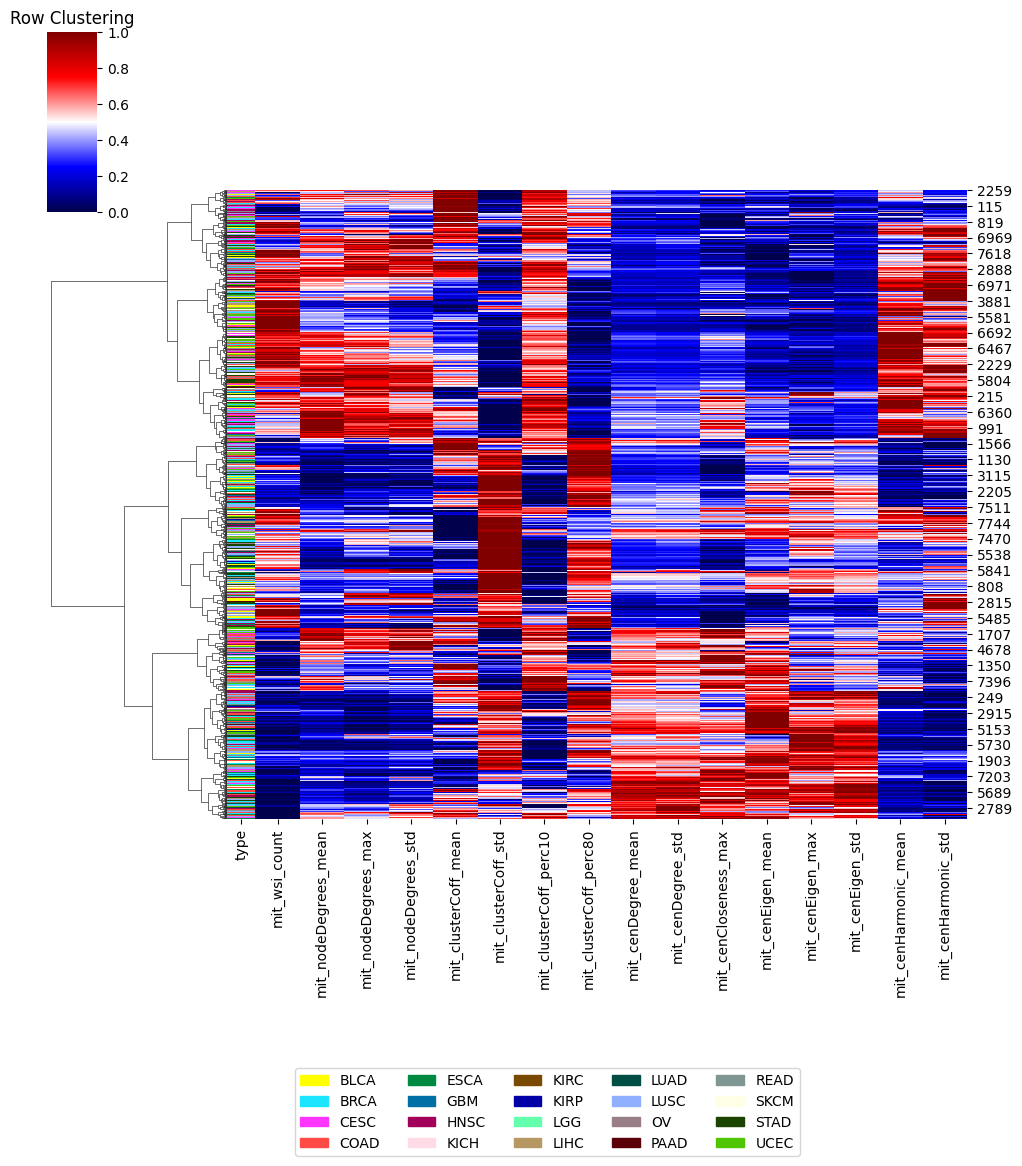

<Figure size 640x480 with 0 Axes>

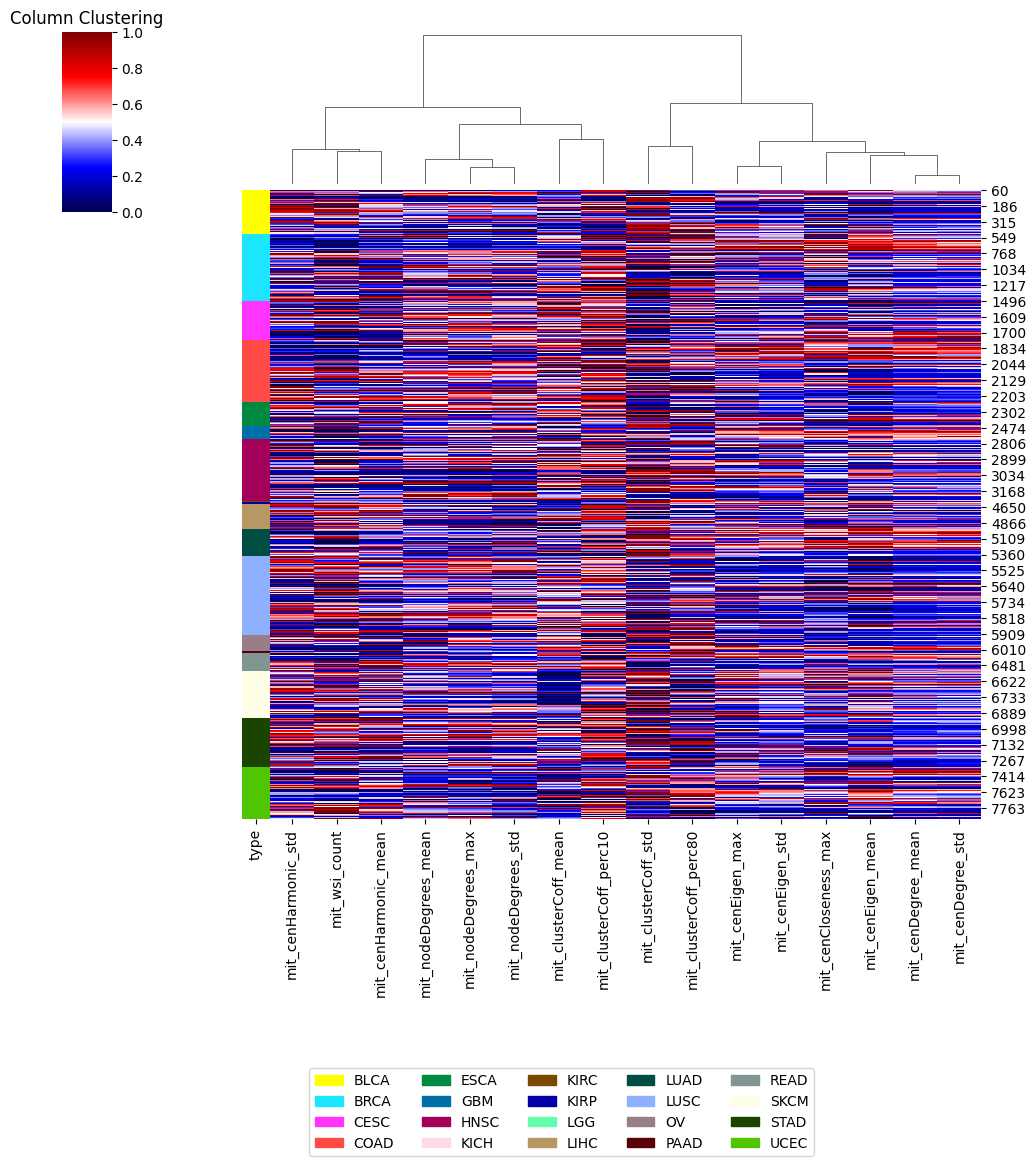

<Figure size 640x480 with 0 Axes>

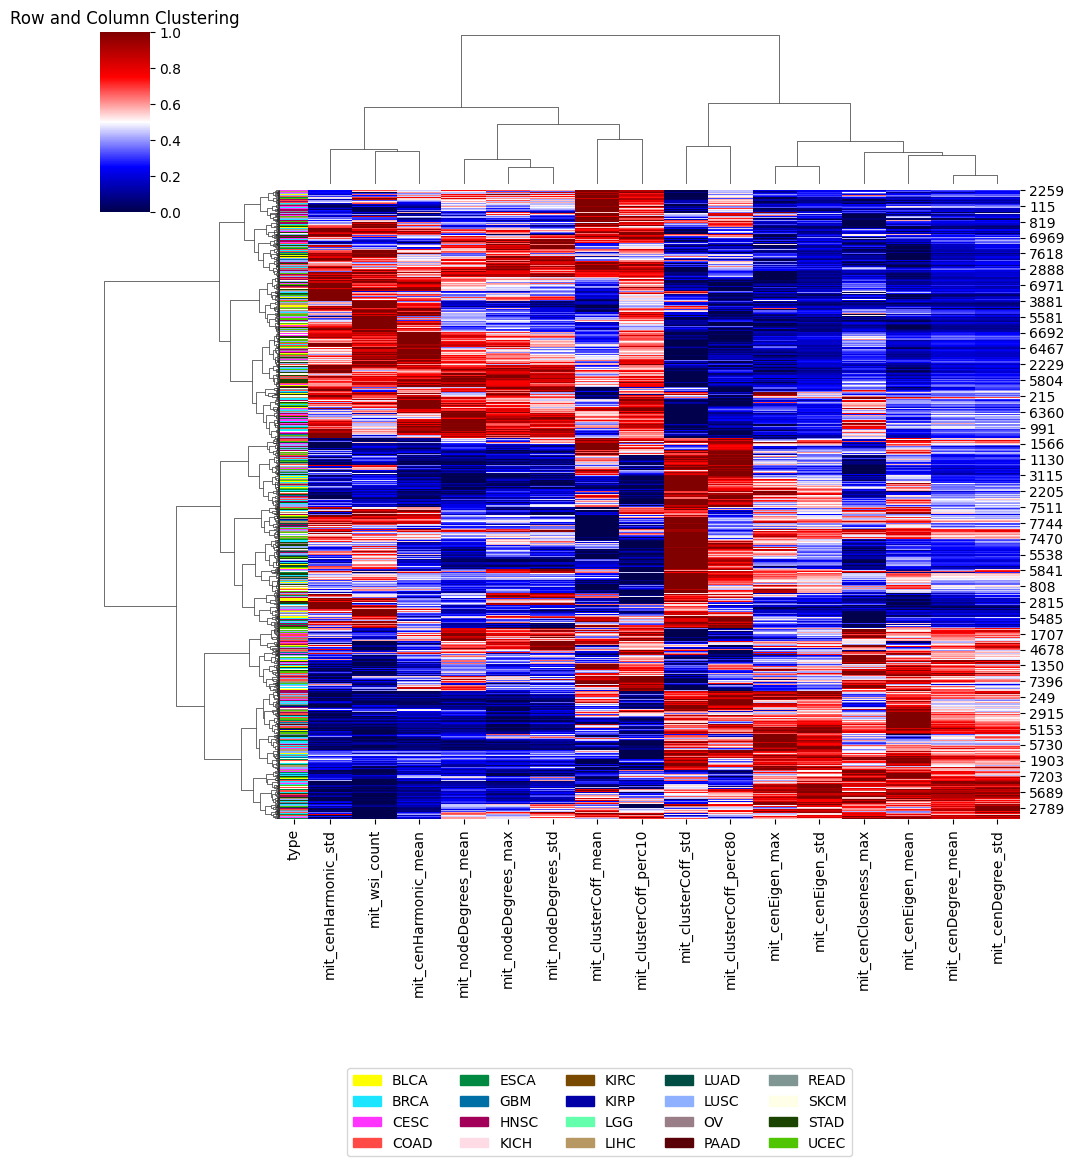

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df = deepcopy(df_ref)
cancer_types = df['type'].unique()


lut = dict(zip(cancer_types,PERCEPTIVE_COLORS_RGB/255.0))
col_colors = df['type'].map(lut)
col_colors.index = df.index.tolist()
df = df.drop('type', axis=1)

# removing the outliers
q_low = df.quantile(0.01)
q_hi  = df.quantile(0.99)
df = df[(df > q_low) & (df < q_hi)]
df = df.dropna()

df=(df-df.mean())/df.std()
# df=(df-df.min())/(df.max()-df.min())

plt.figure(),
g = sns.clustermap(df,cmap='seismic',row_cluster=True,method='ward',col_cluster=False,row_colors=col_colors, standard_scale=0, cbar_kws={"shrink": 0.5})
legend_patches = [mpatches.Patch(color=lut[i], label=i) for i in cancer_types]
plt.legend(handles=legend_patches, bbox_to_anchor=(10, -5), loc='center', ncol=len(cancer_types)//4)
plt.title('Row Clustering')

plt.figure(),
g = sns.clustermap(df,cmap='seismic',row_cluster=False,method='ward',col_cluster=True,row_colors=col_colors, standard_scale=0, cbar_kws={"shrink": 0.5})
legend_patches = [mpatches.Patch(color=lut[i], label=i) for i in cancer_types]
plt.legend(handles=legend_patches, bbox_to_anchor=(10, -5), loc='center', ncol=len(cancer_types)//4)
plt.title('Column Clustering')

plt.figure(),
g = sns.clustermap(df,cmap='seismic',row_cluster=True,method='ward',col_cluster=True,row_colors=col_colors, standard_scale=0, cbar_kws={"shrink": 0.5})
legend_patches = [mpatches.Patch(color=lut[i], label=i) for i in cancer_types]
plt.legend(handles=legend_patches, bbox_to_anchor=(10, -5), loc='center', ncol=len(cancer_types)//4)
plt.title('Row and Column Clustering')

(127, 3)